In [35]:
import numpy as np
import os 
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torch import nn
import torchsummary
from torch.utils.data import DataLoader
from collections import defaultdict
from torchvision.utils import make_grid
import matplotlib.image as mpimg
from collections import Counter

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [37]:
CLASS_NAME_TO_ID = {'Unformed': 0, 'Burr': 1}
CLASS_ID_TO_NAME = {0: 'Unformed', 1: 'Burr'}
BOX_COLOR = {'Unformed':(200, 0, 0), 'Burr':(0, 0, 200)}
TEXT_COLOR = (255, 255, 255)

def save_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))


def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=2):
    x_center, y_center, w, h = bbox
    x_min = int(x_center - w/2)
    y_min = int(y_center - h/2)
    x_max = int(x_center + w/2)
    y_max = int(y_center + h/2)
    
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color[class_name], thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color[class_name], -1)
    cv2.putText(
        image,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return image


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
#         print('category_id: ',category_id)
        class_name = CLASS_ID_TO_NAME[category_id.item()]
        img = visualize_bbox(img, bbox, class_name)
    return img

In [38]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list


In [39]:
class PET_dataset():
    def __init__(self,part,neck_dir,body_dir,phase, transformer=None, aug=None, aug_factor=0):
        self.neck_dir=neck_dir
        self.body_dir=body_dir
        self.part=part
        self.phase=phase
        self.transformer=transformer
        self.aug=aug
        self.aug_factor=aug_factor
        if(self.part=="body"):
            self.image_files = sorted([fn for fn in os.listdir(self.body_dir+"/"+self.phase+"/image") if fn.endswith("jpg")])
            self.label_files= sorted([lab for lab in os.listdir(self.body_dir+"/"+self.phase+"/label") if lab.endswith("txt")])
        elif(self.part=="neck"):
            self.image_files = sorted([fn for fn in os.listdir(self.neck_dir+"/"+self.phase+"/image") if fn.endswith("jpg")])
            self.label_files= sorted([lab for lab in os.listdir(self.neck_dir+"/"+self.phase+"/label") if lab.endswith("txt")])
        
        self.auged_img_list, self.auged_label_list=self.make_aug_list(self.image_files, self.label_files)
        
    def __getitem__(self,index):
        if(self.aug==None):
            filename, image = self.get_image(self.part, index)
            bboxes, class_ids = self.get_label(self.part, index)

            if(self.transformer):
                transformed_data=self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
                image = transformed_data['image']
                bboxes = np.array(transformed_data['bboxes'])
                class_ids = np.array(transformed_data['class_ids'])


            target = {}
    #         print(f'bboxes:{bboxes}\nclass_ids:{class_ids}\nlen_bboxes:{len(bboxes)}\nlen_class_ids:{len(class_ids)}')
    #         print(f'filename: {filename}')
            target["boxes"] = torch.Tensor(bboxes).float()
            target["labels"] = torch.Tensor(class_ids).long()

            ###
            bboxes=torch.Tensor(bboxes).float()
            class_ids=torch.Tensor(class_ids).long()
            target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
            ###
        else:
            image=self.auged_img_list[index][1]
            target=self.auged_label_list[index]
            filename=self.auged_img_list[index][0]
        return image, target, filename
    
    def __len__(self, ):
        length=0
        if(self.aug==None):
            length=len(self.image_files)
        else:
            length=len(self.auged_img_list)
        return length
    
    def make_aug_list(self,ori_image_list,ori_label_files):
        aug_image_list=[]
        aug_label_list=[]
        
        print(f"start making augmented images-- augmented factor:{self.aug_factor}")
        for i in range(len(ori_image_list)):
            filename, ori_image = self.get_image(self.part, i)
            ori_bboxes, ori_class_ids = self.get_label(self.part, i)
            for j in range(self.aug_factor):
                auged_data=self.aug(image=ori_image, bboxes=ori_bboxes, class_ids=ori_class_ids)
                image = auged_data['image']
                bboxes = np.array(auged_data['bboxes'])
                class_ids = np.array(auged_data['class_ids'])
                
                bboxes=torch.Tensor(bboxes).float()
                class_ids=torch.Tensor(class_ids).long()
                
                aug_image_list.append((filename, image))
                aug_label_list.append(np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1))
        
        print(f"total length of augmented images: {len(aug_image_list)}")
        
        return aug_image_list, aug_label_list
        
    
    def get_image(self, part, index): # 이미지 불러오는 함수
        filename = self.image_files[index]
        if(part=="body"):
#             print(f"body called!-> {self.part}")
            image_path = self.body_dir+"/"+self.phase+"/image/"+filename
        elif(part=="neck"):
#             print(f"neck called!-> {self.part}")
            image_path = self.neck_dir+"/"+self.phase+"/image/"+filename
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, part, index): # label (box좌표, class_id) 불러오는 함수
        label_filename=self.label_files[index]
        if(part=="body"):
#             print(f"body label called!-> {self.part}")
            label_path = self.body_dir+"/"+self.phase+"/label/"+label_filename
        elif(part=="neck"):
#             print(f"neck label called!-> {self.part}")
            label_path = self.neck_dir+"/"+self.phase+"/label/"+label_filename
        with open(label_path, 'r') as file:
            labels = file.readlines()
        
        class_ids=[]
        bboxes=[]
        for label in labels:
            label=label.replace("\n", "")
            obj=label.split(' ')[0]
            coor=label.split(' ')[1:]
            obj=int(obj)
            coor=list(map(float, coor))
            class_ids.append(obj)
            bboxes.append(coor)
            
        return bboxes, class_ids
    

# YOLO-CBAM

In [11]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.ca(out) * out
        out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=12, kernel_size=2, padding=0, stride=2,bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.head(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

        return x


def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet34_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet34'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet50_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet50'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet101_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet101'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model


def resnet152_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet152'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

## YOLO-ResNet

In [9]:
class YOLO_RESNET18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.num_bboxes = 2
        self.grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained = True)
#         swin=torchvision.models.swin_v2_t(weights='IMAGENET1K_V1')
        layers = [m for m in resnet18.children()] #Resnet에서 Yolo에서 가져올수 있을만한 layer만 선별적으로 가져오기 위해서

        # 기존 Resnet18의 layer들중에서 맨 뒤에 두개만 제외하고 다 가져와서 Backbone으로 사용
        self.backbone = nn.Sequential(*layers[:-2]) 
        self.head = nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
                nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))
            )

    def forward(self, x):
        out = self.backbone(x)
        # out = self.neck(out)
        out = self.head(out) # input (batch, 3, 448, 448) -> output feature (batch, 12, 7, 7)
        return out


## YOLO-Swin

In [40]:
class YOLO_SWIN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.num_bboxes = 2
        self.grid_size = 7

#         resnet18 = torchvision.models.resnet18(pretrained = True)
        swin=torchvision.models.swin_v2_t(weights='IMAGENET1K_V1')
        layers = [m for m in swin.children()] #Resnet에서 Yolo에서 가져올수 있을만한 layer만 선별적으로 가져오기 위해서

        # 기존 Resnet18의 layer들중에서 맨 뒤에 두개만 제외하고 다 가져와서 Backbone으로 사용
        self.backbone = nn.Sequential(*layers[:-3]) 
        self.head = nn.Sequential(
                nn.Conv2d(in_channels=768, out_channels=1024, kernel_size=1, padding=0,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
                nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))
            )

    def forward(self, x):
        out = self.backbone(x)
        # out = self.neck(out)
        out = self.head(out) # input (batch, 3, 448, 448) -> output feature (batch, 12, 7, 7)
        return out


In [41]:
NUM_CLASSES = 2
model = YOLO_SWIN(num_classes=NUM_CLASSES)
# model = resnet50_cbam(pretrained=True)
model.to(device)

YOLO_SWIN(
  (backbone): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlockV2(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttentionV2(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (cpb_mlp): Sequential(
              (0): Linear(in_features=2, out_features=512, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=512, out_features=3, bias=False)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_f

In [42]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
#     model = YOLO_SWIN(num_classes=num_classes)
    model = YOLO_SWIN(num_classes=num_classes)
#     model = resnet50_cbam(pretrained=True)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [43]:
IMAGE_SIZE=448
transformer = A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
)

## 학습된 모델 가져오기

In [44]:
# ckpt_path="./trained_model/YOLO_SWIN_T_body_LR0.0001_AUG30/model_90.pth"
ckpt_path="/workspace/Plastic_Bottle_defect_detection/experiments/trained_model/YOLO_SWIN_T_neck_LR0.0001_IP50_AUG4_radio_pretrained/model_100.pth"
model = load_model(ckpt_path, NUM_CLASSES, device)
model_name=ckpt_path.split("/workspace/Plastic_Bottle_defect_detection/experiments/trained_model/")[1].split("/model")[0]
model_name

'YOLO_SWIN_T_neck_LR0.0001_IP50_AUG4_radio_pretrained'

## Test dataset가져오기

In [45]:
NECK_PATH = '/home/host_data/PET_data/Neck'
BODY_PATH = '/home/host_data/PET_data/Body'
test_dataset=PET_dataset("neck" ,neck_dir=NECK_PATH,body_dir=BODY_PATH,phase='test', transformer=transformer, aug=None)
test_dataloaders = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

start making augmented images-- augmented factor:0
total length of augmented images: 0


In [46]:
@torch.no_grad()
def model_predict(image, model, conf_thres=0.2, iou_threshold=0.1):
    predictions = model(image)
    prediction = predictions.detach().cpu().squeeze(dim=0)
#     print(prediction.shape)
    
    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE/grid_size

    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
    h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)
    
    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)

    # x_min과 y_min이 음수가 되지않고, x_max와 y_max가 이미지 크기를 넘지 않게 제한
    prediction_res[:, 2].clip(min=0, max=image.shape[1]) 
    prediction_res[:, 3].clip(min=0, max=image.shape[0])
        
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    
    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]
    
    # 이미지 값이 들어가면 모델을 통해서, 후처리까지 포함된 yolo 포멧의 box좌표, 그 좌표에 대한 confidence score
    # 그리고 class id를 반환
    return bboxes, scores, class_ids

In [47]:
def convertToAbsoluteValues(size, box):
    
#     xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
#     yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
#     xEnd = xIn + round(float(box[2]) * size[0])
#     yEnd = yIn + round(float(box[3]) * size[1])
    xIn = round(((2 * float(box[0]) - float(box[2])) / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) / 2))
    xEnd = xIn + round(float(box[2]))
    yEnd = yIn + round(float(box[3]))
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
        
    return (xIn/size[0], yIn/size[1], xEnd/size[0], yEnd/size[1])
#     return (xIn, yIn, xEnd, yEnd)

## Detection한 결과 폴더로 만들어주기(VOC type)

In [16]:
# detection 만들기
pred_images = []
pred_labels =[]

for index, batch in enumerate(test_dataloaders):
    images = batch[0].to(device)
    filename=batch[2]
    print(images.shape)
    
    bboxes, scores, class_ids = model_predict(images, model, conf_thres=0.1, iou_threshold=0.1)
    
    if len(bboxes) > 0:
        prediction_yolo = np.concatenate([bboxes, scores[:, np.newaxis], class_ids[:, np.newaxis]], axis=1)
    else:
        prediction_yolo = np.array([])
    
    # 텐서형의 이미지를 다시 unnormalize를 시키고, 다시 chw를 hwc로 바꾸고 넘파이로 바꾼다.
    np_image = make_grid(images[0], normalize=True).cpu().permute(1,2,0).numpy()
    pred_images.append(np_image)
    pred_labels.append(prediction_yolo)
    print(f"filename:{filename}, prediction_yolo:{prediction_yolo}\n")
#     print(f"{convertToAbsoluteValues(size=(images.shape[2],images.shape[3]),box=prediction_yolo[0][0:4])}")
    txt_name=filename[0].split(".")[0]+".txt"
    os.makedirs(f"/home/host_data/PET_data_for_measure/Neck/test/label/detection/{model_name}", exist_ok=True)
    f = open(f"/home/host_data/PET_data_for_measure/Neck/test/label/detection/{model_name}/"+txt_name, 'w')
    for i in range(len(prediction_yolo)):
        print(f"box={prediction_yolo[i][0:4]}")
        c=convertToAbsoluteValues(size=(images.shape[2],images.shape[3]),box=prediction_yolo[i][0:4])
        print(f"size={(images.shape[2],images.shape[3])}, c--{c}")
        text=f"{int(prediction_yolo[i][5])} {prediction_yolo[i][4]} {c[0]} {c[1]} {c[2]} {c[3]}\n"
        f.write(text)

    

torch.Size([1, 3, 448, 448])
filename:['shape1_121.jpg'], prediction_yolo:[]

torch.Size([1, 3, 448, 448])
filename:['shape1_148.jpg'], prediction_yolo:[[4.1050180e+02 3.0168433e+02 1.7601929e+01 6.6251282e+01 2.8365284e-01
  0.0000000e+00]
 [2.6889191e+02 9.7711563e+01 7.0338440e+01 9.1208214e+01 2.3559202e-01
  0.0000000e+00]]

box=[410.5018   301.68433   17.601929  66.25128 ]
size=(448, 448), c--(0.8973214285714286, 0.6004464285714286, 0.9375, 0.7477678571428571)
box=[268.8919   97.71156  70.33844  91.20821]
size=(448, 448), c--(0.5223214285714286, 0.11607142857142858, 0.6785714285714286, 0.31919642857142855)
torch.Size([1, 3, 448, 448])
filename:['shape1_153.jpg'], prediction_yolo:[[8.6491661e+01 1.3657610e+02 6.5889175e+01 9.8409668e+01 6.6311425e-01
  0.0000000e+00]
 [2.3632222e+02 2.6496579e+02 2.1246643e+01 6.1194519e+01 1.7328086e-01
  0.0000000e+00]
 [2.1026909e+02 2.6489969e+02 2.0935486e+01 5.9485641e+01 1.1416510e-01
  0.0000000e+00]]

box=[ 86.49166  136.5761    65.889175

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3423.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


filename:['shape1_80.jpg'], prediction_yolo:[[5.50527191e+01 1.80102325e+02 6.12992554e+01 1.21507904e+02
  4.58075970e-01 0.00000000e+00]
 [3.76505280e+02 2.86216766e+02 1.88133545e+01 5.14103394e+01
  3.54477644e-01 0.00000000e+00]]

box=[ 55.05272  180.10233   61.299255 121.507904]
size=(448, 448), c--(0.05357142857142857, 0.265625, 0.18973214285714285, 0.5379464285714286)
box=[376.50528  286.21677   18.813354  51.41034 ]
size=(448, 448), c--(0.8191964285714286, 0.5825892857142857, 0.8616071428571429, 0.6964285714285714)
torch.Size([1, 3, 448, 448])
filename:['shape1_99.jpg'], prediction_yolo:[[237.09749    264.32712     29.803772    74.97247      0.46185964
    0.        ]]

box=[237.09749  264.32712   29.803772  74.97247 ]
size=(448, 448), c--(0.4955357142857143, 0.5066964285714286, 0.5625, 0.6741071428571429)
torch.Size([1, 3, 448, 448])
filename:['shape2_105.jpg'], prediction_yolo:[[2.42235474e+02 1.53279938e+02 3.47375488e+01 8.94444275e+01
  5.25501907e-01 0.00000000e+00]
 [1.

filename:['shape3_44.jpg'], prediction_yolo:[[377.22568    157.9379      23.77118     95.55408      0.58336186
    0.        ]]

box=[377.22568 157.9379   23.77118  95.55408]
size=(448, 448), c--(0.8147321428571429, 0.24553571428571427, 0.8683035714285714, 0.45982142857142855)
torch.Size([1, 3, 448, 448])
filename:['shape4_24.jpg'], prediction_yolo:[[ 76.15267   149.28328    26.304764   67.15011     0.3344771   0.       ]]

box=[ 76.15267  149.28328   26.304764  67.15011 ]
size=(448, 448), c--(0.140625, 0.25892857142857145, 0.19866071428571427, 0.40848214285714285)
torch.Size([1, 3, 448, 448])
filename:['shape5_34.jpg'], prediction_yolo:[[309.44547   218.00372    30.458923   53.241577    0.5196457   0.       ]]

box=[309.44547  218.00372   30.458923  53.241577]
size=(448, 448), c--(0.65625, 0.4263392857142857, 0.7232142857142857, 0.5446428571428571)
torch.Size([1, 3, 448, 448])
filename:['shape6_34.jpg'], prediction_yolo:[[1.1509949e+02 1.8212721e+02 2.4891708e+01 5.5939758e+01 3.03168

## Detection한 결과 Plot

In [17]:

from ipywidgets import interact

@interact(index=(0,len(pred_images)-1))
def show_result(index=0):
    print(pred_labels[index])
    if len(pred_labels[index]) > 0:
        result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 5])
    else:
        result = pred_images[index]
        
    plt.figure(figsize=(6,6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=24), Output()), _dom_classes=('widget-intera…

In [48]:
def convertToAbsoluteValues_size(size, box):
    
#     xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
#     yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
#     xEnd = xIn + round(float(box[2]) * size[0])
#     yEnd = yIn + round(float(box[3]) * size[1])
    xIn = (2 * float(box[0]) - float(box[2])) / 2
    yIn = (2 * float(box[1]) - float(box[3])) / 2
    xEnd = xIn + float(box[2])
    yEnd = yIn + float(box[3])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
        
    return (xIn, yIn, xEnd, yEnd)

## Annotation을 폴더로 만들어주기(VOC type)

## 탐지성능검증을 위한 지표 적용

In [49]:
# 0: 'Unformed', 1: 'Burr'
num2class = {"0.0" : "Unformed", "1.0" : "Burr"}

In [50]:
# box : (centerX, centerY, width, height)
def convertToAbsoluteValues(size, box):
    
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

# def convertToRelativeValues(size, box):
#     dw = 1. / (size[0])
#     dh = 1. / (size[1])
#     cx = (box[1] + box[0]) / 2.0
#     cy = (box[3] + box[2]) / 2.0
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = cx * dw
#     y = cy * dh
#     w = w * dw
#     h = h * dh
#     # x,y => (bounding_box_center)/width_of_the_image
#     # w => bounding_box_width / width_of_the_image
#     # h => bounding_box_height / height_of_the_image
#     return (x, y, w, h)

In [21]:
def boundingBoxes(labelPath, imagePath, model_name):
    
    detections, groundtruths, classes = [], [], []
    
    for boxtype in os.listdir(labelPath):
        
        if boxtype=="detection":
            boxtypeDir=labelPath+boxtype+"/"+model_name+"/"
        else:
            boxtypeDir = os.path.join(labelPath,boxtype)

        for labelfile in os.listdir(boxtypeDir):
            if labelfile ==".ipynb_checkpoints":
                continue
            filename = os.path.splitext(labelfile)[0]
            with open(os.path.join(boxtypeDir, labelfile)) as f:
                labelinfos = f.readlines()

            imgfilepath = os.path.join(imagePath, filename + ".jpg")
            print(imgfilepath )
            img = cv2.imread(imgfilepath)
            print(img.shape)
            h, w, _ = img.shape

            for labelinfo in labelinfos:
                label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
#                 x1, y1, x2, y2 = convertToAbsoluteValues((448, 448), (rx1, ry1, rx2, ry2))
#                 boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
                boxinfo = [filename, label, conf, (rx1*448, ry1*448, rx2*448, ry2*448)]
                
                if label not in classes:
                    classes.append(label)
                
                if boxtype == "detection":
                    detections.append(boxinfo)
                else:
                    groundtruths.append(boxinfo)
                    
    classes = sorted(classes)
                
    return detections, groundtruths, classes

detections, groundtruths, classes = boundingBoxes(f"/home/host_data/PET_data_for_measure/Neck/test/label/", "/home/host_data/PET_data_for_measure/Neck/test/image/",model_name)
print(f"detections:{detections}\n\n")
print(f"groundtruths:{groundtruths}\n\n")
print(f"classes:{classes}\n\n")

/home/host_data/PET_data_for_measure/Neck/test/image/shape1_48.jpg
(296, 1209, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_151.jpg
(265, 1235, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_81.jpg
(289, 1233, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_75.jpg
(253, 1230, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_127.jpg
(290, 1236, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_53.jpg
(267, 1222, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_79.jpg
(258, 1230, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_55.jpg
(251, 1225, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape1_148.jpg
(303, 1231, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_14.jpg
(268, 1233, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape1_121.jpg
(310, 1238, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape3_15.jpg
(232, 1241, 3)
/home/host_d

In [51]:
transformer = A.Compose([ 
        # bounding box의 변환, augmentation에서 albumentations는 Detection 학습을 할 때 굉장히 유용하다. 
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
#         A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        # albumentations 라이브러리에서는 Normalization을 먼저 진행해 주고 tensor화를 진행해 주어야한다.
    ]
    
)

## Prediction & Annotation 비교이미지 저장

(448, 448, 3)
shape1_121
[(51.74780488014221, 273.13552379608154, 76.71708464622498, 338.16765308380127, 1.0)]


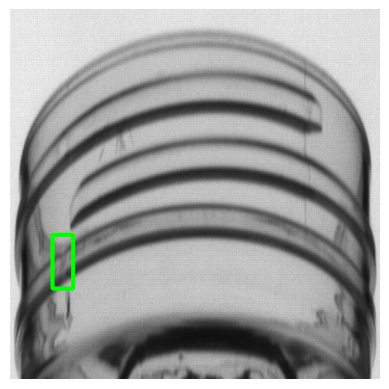

(448, 448, 3)
shape1_148
[(402.0, 269.0, 420.0, 335.0, 0.2836528420448303), (234.0, 52.0, 304.0, 143.0, 0.23559202253818512), (223.09011936187744, 53.22777700424194, 296.6042318344116, 143.4191403388977, 1.0)]


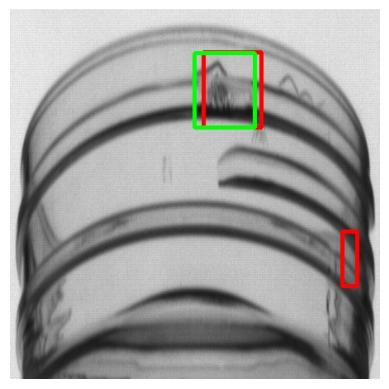

(448, 448, 3)
shape1_153
[(54.0, 87.0, 120.0, 185.0, 0.6631142497062683), (226.0, 234.0, 247.0, 295.0, 0.17328086495399475), (200.0, 235.0, 221.0, 294.0, 0.11416509747505188), (62.03635311126709, 105.86307716369629, 134.47436618804932, 182.57546043395996, 1.0), (215.82735633850098, 223.99998998641968, 239.2304286956787, 289.9724678993225, 1.0)]


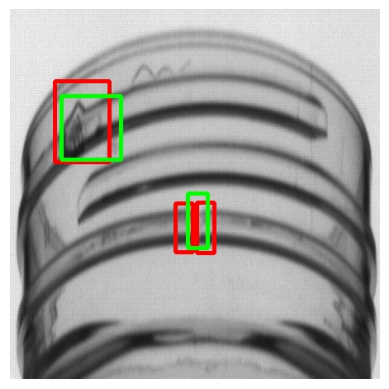

(448, 448, 3)
shape1_48
[(409.0, 294.0, 424.0, 351.0, 0.28999412059783936), (27.0, 187.0, 55.0, 262.0, 0.20124661922454834), (393.0, 298.0, 405.0, 357.0, 0.19968563318252563), (395.01077902317047, 295.1352262496948, 413.1677716970444, 352.6485719680786, 1.0)]


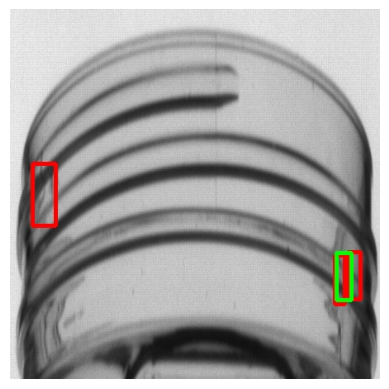

(448, 448, 3)
shape1_65
[(197.0, 48.0, 259.0, 140.0, 0.5956549644470215), (139.0, 236.99999999999997, 170.0, 302.0, 0.3432161211967468), (197.6360855102539, 51.286367416381836, 258.8445358276367, 152.3502426147461, 1.0), (146.75202786922455, 238.32995748519897, 167.40079653263092, 294.141348361969, 1.0)]


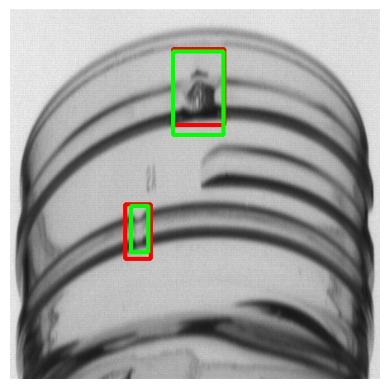

(448, 448, 3)
shape1_80
[(24.0, 119.0, 85.0, 241.0, 0.45807597041130066), (367.0, 261.0, 386.0, 312.0, 0.3544776439666748), (13.306719779968262, 123.63634777069092, 84.64669036865234, 247.27270221710205, 1.0), (365.57114827632904, 258.9088280200958, 384.7921406030655, 314.1817252635956, 1.0)]


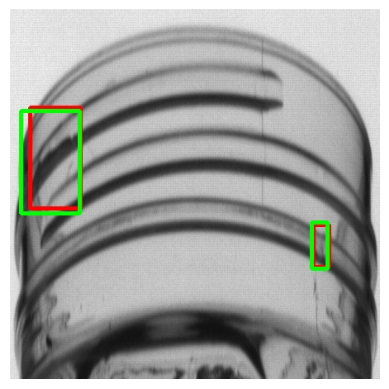

(448, 448, 3)
shape1_99
[(222.0, 227.0, 252.0, 302.0, 0.46185964345932007), (216.64361000061035, 229.42573499679565, 240.91938591003418, 303.83405351638794, 1.0)]


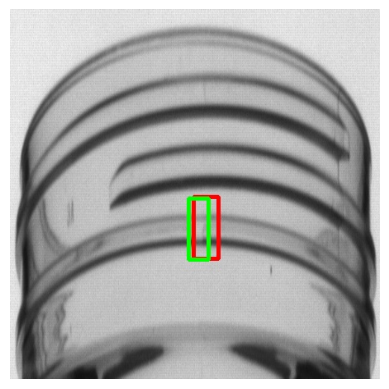

(448, 448, 3)
shape2_105
[(225.00000000000003, 109.0, 260.0, 198.0, 0.5255019068717957), (4.0, 0.0, 23.0, 210.0, 0.15814195573329926), (190.0, 296.0, 278.0, 377.0, 0.12070493400096893), (235.8471486568451, 108.13779211044312, 258.8120768070221, 197.3946213722229, 1.0)]


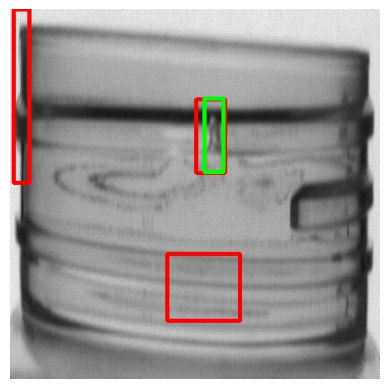

(448, 448, 3)
shape2_127
[(98.0, 135.0, 125.0, 207.0, 0.6053447127342224), (423.0, 113.0, 445.0, 201.0, 0.32366153597831726), (405.0, 126.0, 428.0, 183.0, 0.1663745492696762), (92.80012965202332, 133.33352899551392, 121.5813057422638, 214.43541860580444, 1.0)]


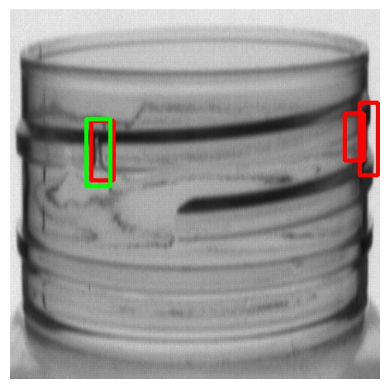

(448, 448, 3)
shape2_135
[(299.0, 64.0, 316.0, 316.0, 0.38921216130256653), (288.0, 63.0, 301.0, 317.0, 0.2652074098587036), (289.1969887018204, 61.01805877685547, 303.0375007390976, 324.3587188720703, 1.0)]


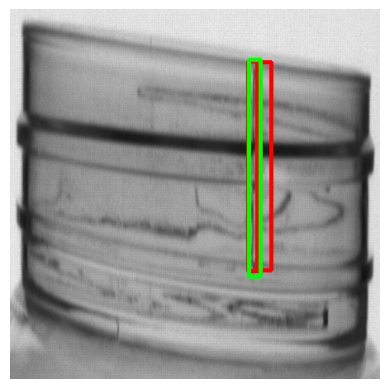

(448, 448, 3)
shape2_14
[(32.0, 24.0, 53.0, 276.0, 0.4681366980075836), (325.0, 138.0, 352.0, 219.0, 0.4304731786251068), (412.0, 243.0, 436.0, 310.0, 0.1905137598514557), (41.77418541908264, 23.397024154663086, 57.93807005882263, 279.3613872528076, 1.0), (334.19540095329285, 121.22230386734009, 356.8786270618439, 209.3040328025818, 1.0)]


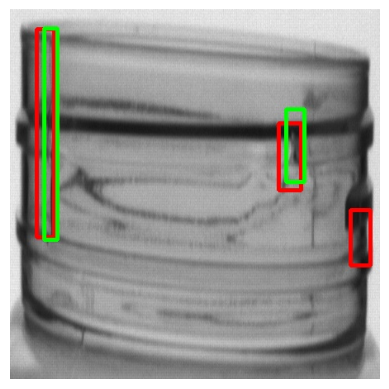

(448, 448, 3)
shape2_151
[(125.0, 116.00000000000001, 162.0, 200.0, 0.6259755492210388), (426.0, 119.0, 444.0, 190.0, 0.16600149869918823), (424.0, 236.99999999999997, 440.0, 299.0, 0.11296840012073517), (198.0, 289.0, 272.0, 372.0, 0.11092723906040192), (137.4835822582245, 113.26805973052979, 170.4940140247345, 199.4870023727417, 1.0)]


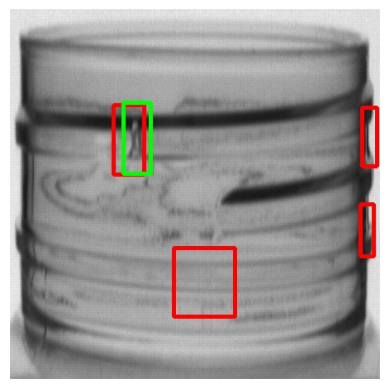

(448, 448, 3)
shape2_53
[(403.0, 108.0, 424.0, 338.0, 0.4297965168952942), (10.0, 72.0, 47.0, 153.0, 0.23661567270755768), (204.0, 299.0, 279.0, 370.0, 0.11943504214286804), (49.07739496231079, 83.40371799468994, 69.08350706100464, 166.0955572128296, 1.0)]


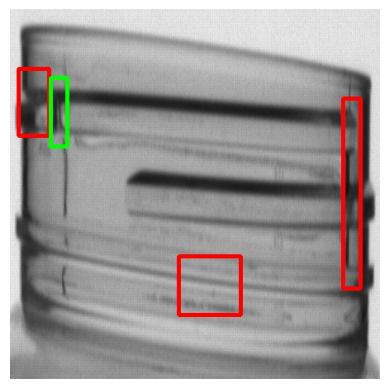

(448, 448, 3)
shape2_55
[(149.0, 99.0, 188.0, 200.0, 0.513047456741333), (421.0, 127.0, 443.0, 193.0, 0.1469632089138031), (424.0, 232.00000000000003, 447.0, 309.0, 0.13010936975479126), (209.0, 302.0, 276.0, 357.0, 0.1094498336315155), (151.40562987327576, 92.8126049041748, 183.22258973121643, 192.764986038208, 1.0)]


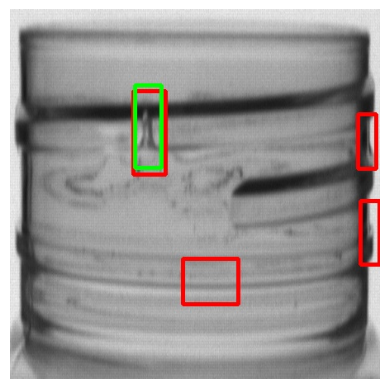

(448, 448, 3)
shape2_70
[(401.0, 107.0, 418.0, 343.0, 0.43913835287094116), (18.0, 82.0, 55.0, 163.0, 0.31631696224212646), (42.87348794937134, 83.60934352874756, 61.196911334991455, 161.5918092727661, 1.0)]


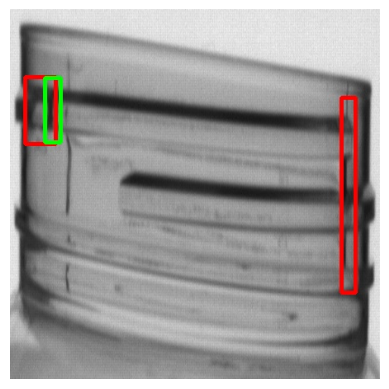

(448, 448, 3)
shape2_75
[(100.0, 99.0, 131.0, 184.0, 0.5753539800643921), (196.0, 293.0, 282.0, 350.0, 0.13540972769260406), (96.52003455162048, 108.01594352722168, 121.28771424293518, 194.78278923034668, 1.0)]


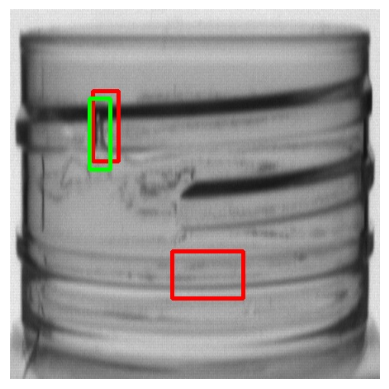

(448, 448, 3)
shape2_79
[(143.0, 108.0, 181.0, 203.0, 0.46980950236320496), (198.0, 298.0, 287.0, 368.0, 0.10805602371692657), (149.33318424224854, 102.44953775405884, 176.6504316329956, 208.3719687461853, 1.0)]


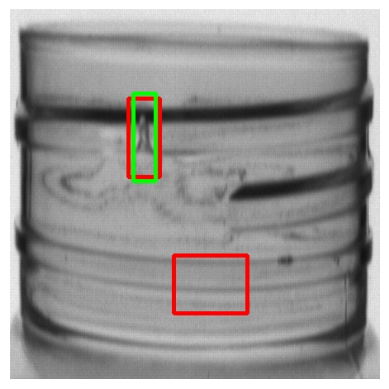

(448, 448, 3)
shape2_81
[(255.0, 131.0, 297.0, 201.0, 0.5869633555412292), (0.0, 0.0, 20.0, 219.0, 0.12354899942874908), (271.0527641773224, 130.21433210372925, 305.20694041252136, 218.57426500320435, 1.0)]


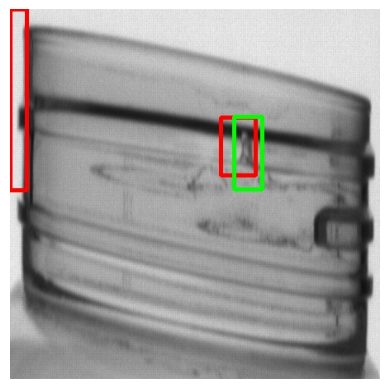

(448, 448, 3)
shape3_12
[(89.0, 139.0, 125.0, 232.00000000000003, 0.537665843963623), (419.0, 177.0, 435.0, 246.00000000000003, 0.1202591210603714), (90.54909014701843, 137.6970500946045, 123.04477047920227, 236.60604286193848, 1.0)]


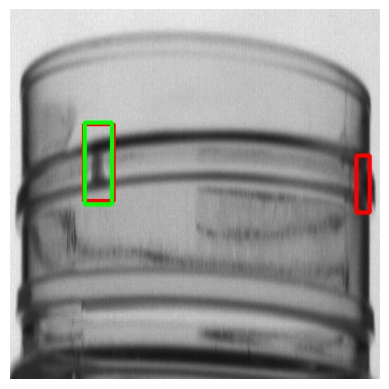

(448, 448, 3)
shape3_14
[(214.0, 141.0, 260.0, 239.00000000000003, 0.5351477861404419), (214.7048840522766, 148.05145931243896, 251.88619565963745, 228.80704593658447, 1.0)]


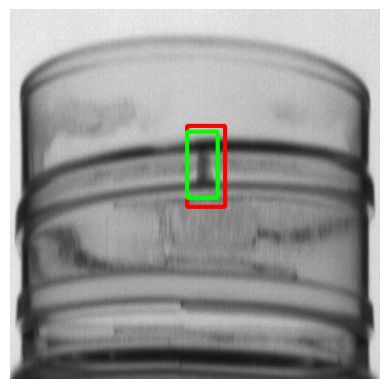

(448, 448, 3)
shape3_15
[(63.0, 148.0, 90.0, 252.0, 0.49900346994400024), (72.71380376815796, 150.98294496536255, 97.81470537185669, 246.10096311569214, 1.0)]


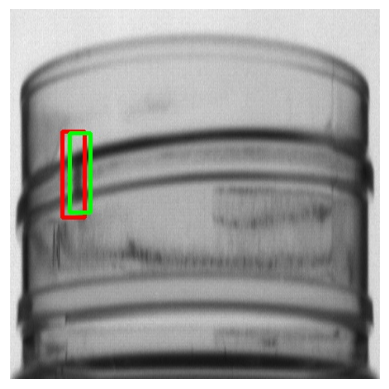

(448, 448, 3)
shape3_44
[(365.0, 110.0, 389.0, 206.0, 0.5833618640899658), (363.7482293844223, 106.66678047180176, 383.52922117710114, 209.45455360412598, 1.0)]


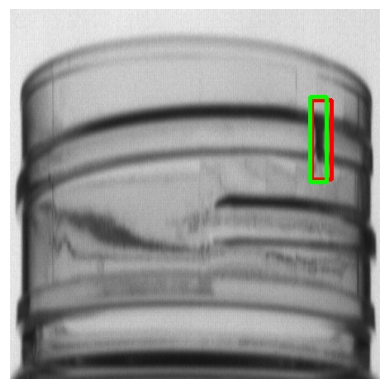

(448, 448, 3)
shape4_24
[(63.0, 116.00000000000001, 89.0, 183.0, 0.33447709679603577), (58.89004611968994, 118.36362028121948, 85.4994535446167, 181.99978303909302, 1.0)]


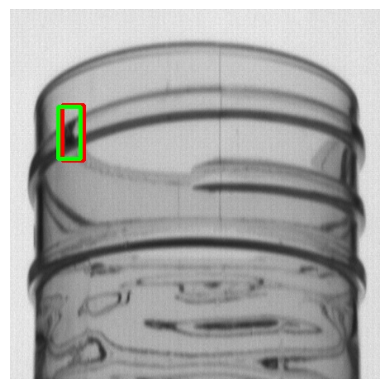

(448, 448, 3)
shape5_34
[(294.0, 191.0, 324.0, 243.99999999999997, 0.5196456909179688), (287.6713237762451, 204.56621408462524, 322.95894050598145, 247.5249342918396, 1.0)]


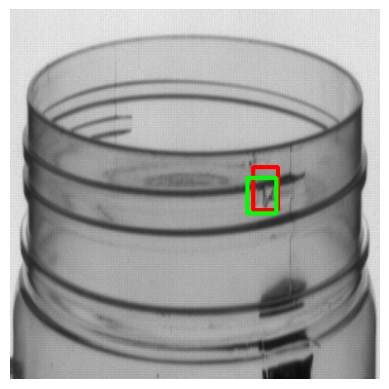

(448, 448, 3)
shape6_34
[(112.38998222351074, 155.76624202728271, 130.7315502166748, 216.4187250137329, 1.0)]


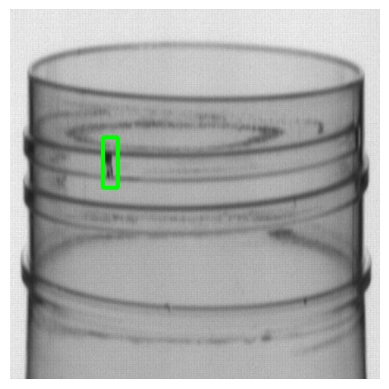

In [23]:
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, labelfile + ".jpg")
        img = cv2.imread(imgfilePath)
        img_t=transformer(image=img)
        img=img_t['image'].permute(1,2,0).numpy()
        print(img.shape)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
        print(labelfile)
        print(rectinfos)
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
                
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), rectcolor, 4)
        os.makedirs(savePath, exist_ok=True)
        cv2.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
        plt.axis("off")
        plt.imshow(img)
        plt.show()
        
# boxPlot(detections, "image", savePath="boxed_images/detection")
# boxPlot(groundtruths, "image", savePath="boxed_images/groundtruth")
boxPlot(detections + groundtruths, "/home/host_data/PET_data_for_measure/Neck/test/image/", savePath=f"/workspace/Plastic_Bottle_defect_detection/results/boxed_images/{model_name}")

## IoU(Intersection over Union)

In [52]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

# boxA = (Ax1,Ay1,Ax2,Ay2)
# boxB = (Bx1,By1,Bx2,By2)
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result

In [53]:
boxA = detections[-1][-1]
boxB = groundtruths[-1][-1]

print(f"boxA coordinates : {(boxA)}")
print(f"boxA area : {getArea(boxA)}")
print(f"boxB coordinates : {(boxB)}")
print(f"boxB area : {getArea(boxB)}")

print(f"Union area of boxA and boxB : {getUnionAreas(boxA, boxB)}")

print(f"Does boxes Intersect? : {boxesIntersect(boxA, boxB)}")

print(f"Intersection area of boxA and boxB : {getIntersectionArea(boxA, boxB)}")

print(f"IoU of boxA and boxB : {iou(boxA, boxB)}")

boxA coordinates : (222.0, 227.0, 252.0, 302.0)
boxA area : 2356.0
boxB coordinates : (216.64361000061035, 229.42573499679565, 240.91938591003418, 303.83405351638794)
boxB area : 1906.0037606076694
Union area of boxA and boxB : 2796.44958296172
Does boxes Intersect? : True
Intersection area of boxA and boxB : 1465.5541776459495
IoU of boxA and boxB : 0.5240767387959775


## AP(Average Precision)

In [54]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [55]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [57]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.3, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]

        npos = len(gts)

        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)

        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))

        det = Counter(cc[0] for cc in gts)

        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)


        for d in range(len(dects)):


            gt = [gt for gt in gts if gt[0] == dects[d][0]]

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)

        r = {
            'class' : c,
            'precision' : prec,
            'recall' : rec,
            'AP' : ap,
            'interpolated precision' : mpre,
            'interpolated recall' : mrec,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }

        result.append(r)

    return result

result = AP(detections, groundtruths, classes,IOUThreshold=0.5)
print(result)

[{'class': 0.0, 'precision': array([1.        , 1.        , 1.        , 1.        , 0.8       ,
       0.83333333, 0.85714286, 0.875     , 0.88888889, 0.9       ,
       0.90909091, 0.91666667, 0.84615385, 0.85714286, 0.86666667,
       0.875     , 0.82352941, 0.83333333, 0.84210526, 0.85      ,
       0.80952381, 0.77272727, 0.73913043, 0.70833333, 0.68      ,
       0.69230769, 0.66666667, 0.64285714, 0.62068966, 0.6       ,
       0.58064516, 0.5625    , 0.54545455, 0.52941176, 0.51428571,
       0.5       , 0.48648649, 0.47368421, 0.46153846, 0.45      ,
       0.43902439, 0.42857143, 0.41860465]), 'recall': array([0.03703704, 0.07407407, 0.11111111, 0.14814815, 0.14814815,
       0.18518519, 0.22222222, 0.25925926, 0.2962963 , 0.33333333,
       0.37037037, 0.40740741, 0.40740741, 0.44444444, 0.48148148,
       0.51851852, 0.51851852, 0.55555556, 0.59259259, 0.62962963,
       0.62962963, 0.62962963, 0.62962963, 0.62962963, 0.62962963,
       0.66666667, 0.66666667, 0.66666667, 0.

## mAP(mean Average Precision)

In [58]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [59]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")

Unformed AP : 0.6031101614434946
  Burr   AP : 0.1
---------------------------
mAP : 0.3515550807217473


## Prediction & Annotation 비교 plot

In [60]:
from ipywidgets import interact
both_path=f"/workspace/Plastic_Bottle_defect_detection/results/boxed_images/{model_name}/"
both_images=os.listdir(both_path)
@interact(index=(0,len(both_images)-1))
def show_result(index=0):
    box_img=cv2.imread(both_path+both_images[index])
    result = pred_images[index]
    print(both_images[index])
        
    plt.figure(figsize=(6,6))
    plt.imshow(box_img)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=24), Output()), _dom_classes=('widget-intera…